# CFL on Galaxy Dataset 
This notebook runs CFL on the galaxy dataset and visualizes the results. X data is comprised of two input images (a gas map and dark matter map). Y data is comprised of six parameters describing the simulated telescope image that results from these input maps.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

cfl_path = '/Users/iwahle/Desktop/cfl' # set this to your own cfl location
sys.path.append(cfl_path) # alternatively, you can permanantly update your PYTHONPATH
import cfl
from cfl.cfl_wrapper import make_CFL
from cfl.save.experiment_saver import ExperimentSaver
from cfl.dataset import Dataset

# Load and Inspect Dataset

In [40]:
# load data
X = np.load(os.path.join(cfl_path, 'data/galaxies/X.npy'))
Y = np.load(os.path.join(cfl_path, 'data/galaxies/Y.npy'))
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

X shape:  (8643, 5202)
Y shape:  (8643, 6)


min img 0:  -111209.03876876831
max img 0:  0.0

min img 1:  0.0
max img 1:  73430.0


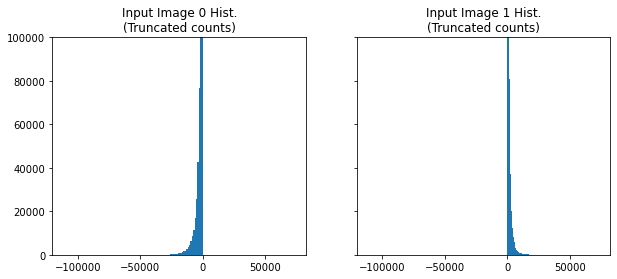

In [124]:
print('min img 0: ', np.min(X[:,:2601]))
print('max img 0: ', np.max(X[:,:2601]))
print()
print('min img 1: ', np.min(X[:,2601:]))
print('max img 1: ', np.max(X[:,2601:]))
fig,ax = plt.subplots(1,2,figsize=(10,4), sharex=True, sharey=True)
ax[0].hist(np.ravel(X[:,:2601]),100)
ax[0].set_title('Input Image 0 Hist.\n(Truncated counts)')
ax[1].hist(np.ravel(X[:,2601:]),100)
ax[1].set_title('Input Image 1 Hist.\n(Truncated counts)')
plt.ylim(0,1e5)
plt.show()


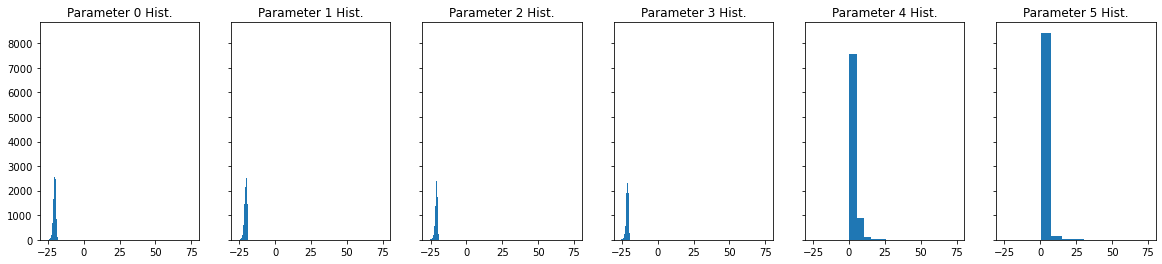

In [122]:
fig,ax = plt.subplots(1,6,figsize=(20,4), sharex=True, sharey=True)
for i in range(6):
    ax[i].hist(Y[:,i],10)
    ax[i].set_title('Parameter {} Hist.'.format(i))
plt.show()


# Run CFL

In [60]:
# start experiment
experiment_saver = ExperimentSaver('results/galaxies')

# register dataset
dataset0 = Dataset(X, Y, dataset_label='dataset0', experiment_saver=experiment_saver)

All results from this run will be saved to results/galaxies/experiment0001


In [61]:
# specify CFL parameters

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# conditional density estimator parameters
CDE_params = { 'batch_size'  : 64,
               'optimizer'   : 'adam',
               'n_epochs'    : 200,
               'verbose'     : 1,
               'opt_config'  : {'lr': 1e-4},
               'dense_units' : [1000, 100, data_info['Y_dims'][1]],
               'activations' : ['relu', 'relu', 'linear'],
               'dropouts'    : [0, 0, 0], 
               'show_plot'   : True }

    
# clusterer parameters
cluster_params = { 'n_Xclusters' : 4, 
                   'n_Yclusters' : 4 }

In [62]:
# build CFL object! 
cfl_object = make_CFL(  data_info=data_info, 
                        CDE_type='CondExpMod', 
                        cluster_type='Kmeans', 
                        CDE_params=CDE_params, 
                        cluster_params=cluster_params,
                        experiment_saver=experiment_saver) 

weights_path not specified in params, defaulting to None
loss not specified in params, defaulting to mean_squared_error
model_name not specified in params, defaulting to CondExpMod


0 - val_loss: 0.6119
Epoch 8/200
102/102 [==============================] - 2s 16ms/step - loss: 0.6385 - val_loss: 0.6349
Epoch 9/200
102/102 [==============================] - 2s 21ms/step - loss: 0.6016 - val_loss: 0.6044
Epoch 10/200
102/102 [==============================] - 2s 20ms/step - loss: 0.5372 - val_loss: 0.5787
Epoch 11/200
102/102 [==============================] - 2s 19ms/step - loss: 0.5628 - val_loss: 0.5389
Epoch 12/200
102/102 [==============================] - 2s 17ms/step - loss: 0.9382 - val_loss: 0.6855
Epoch 13/200
102/102 [==============================] - 2s 17ms/step - loss: 0.6084 - val_loss: 0.6048
Epoch 14/200
102/102 [==============================] - 2s 18ms/step - loss: 0.5945 - val_loss: 0.6609
Epoch 15/200
102/102 [==============================] - 2s 18ms/step - loss: 0.5909 - val_loss: 0.5958
Epoch 16/200
102/102 [==============================] - 2s 18ms/step - loss: 0.5781 - val_loss: 0.5646
Epoch 17/200
102/102 [==============================] 

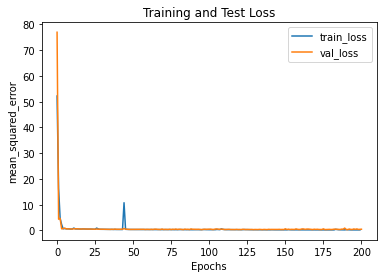

Loading parameters from  results/galaxies/experiment0001/dataset0/checkpoints/best_weights
100%|██████████| 8643/8643 [00:06<00:00, 1379.15it/s]


In [63]:
# train
train_results = cfl_object.train(dataset0, standardize=True)

In [69]:
# predict
dataset1 = Dataset(X[:1000,:], Y[:1000,:], dataset_label='dataset1', experiment_saver=experiment_saver) 
xlbls,ylbls = cfl_object.predict(dataset1)


100%|██████████| 1000/1000 [00:00<00:00, 7209.28it/s]


# Visualization

In [91]:
def reshape_input(vec, im_no):
    if im_no==0:
        return np.reshape(vec[:2601],(51,51))
    elif im_no==1:
        return np.reshape(vec[2601:],(51,51))
    elif im_no==2:
        return np.hstack([np.reshape(vec[:2601],(51,51)), np.reshape(vec[2601:],(51,51))])
    else:
        return

Examples of Input Image 0 by Class


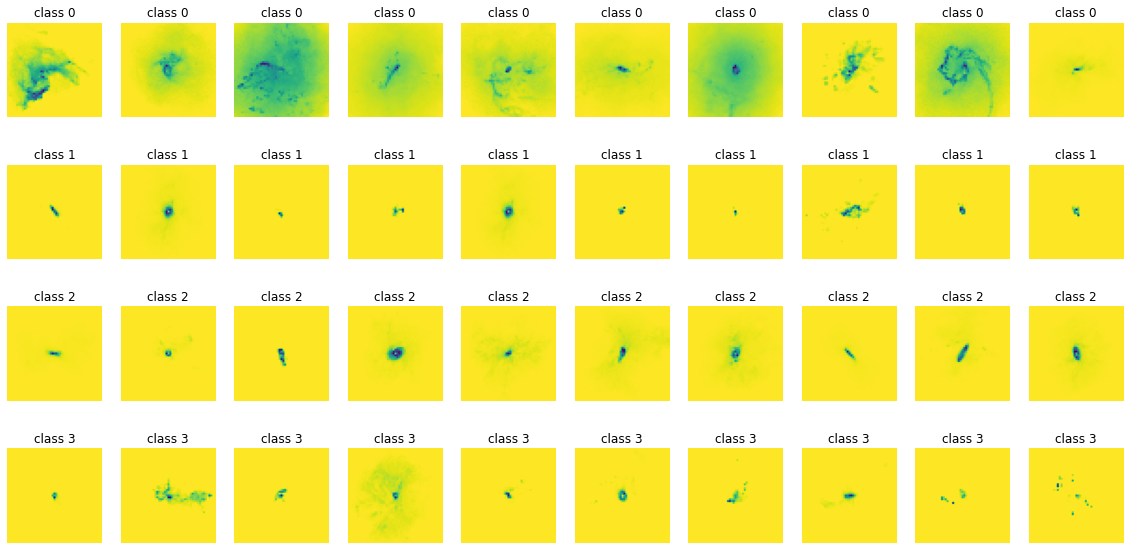

In [127]:
print('Examples of Input Image 0 by Class')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], 10, figsize=(20,10))
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 10)
    for j in range(10):
        ax[i,j].imshow(reshape_input(dataset1.X[class_samples[j]],0))
        ax[i,j].set_title('class {}'.format(i))
        ax[i,j].axis('off')
plt.show()


Examples of Input Image 1 by Class


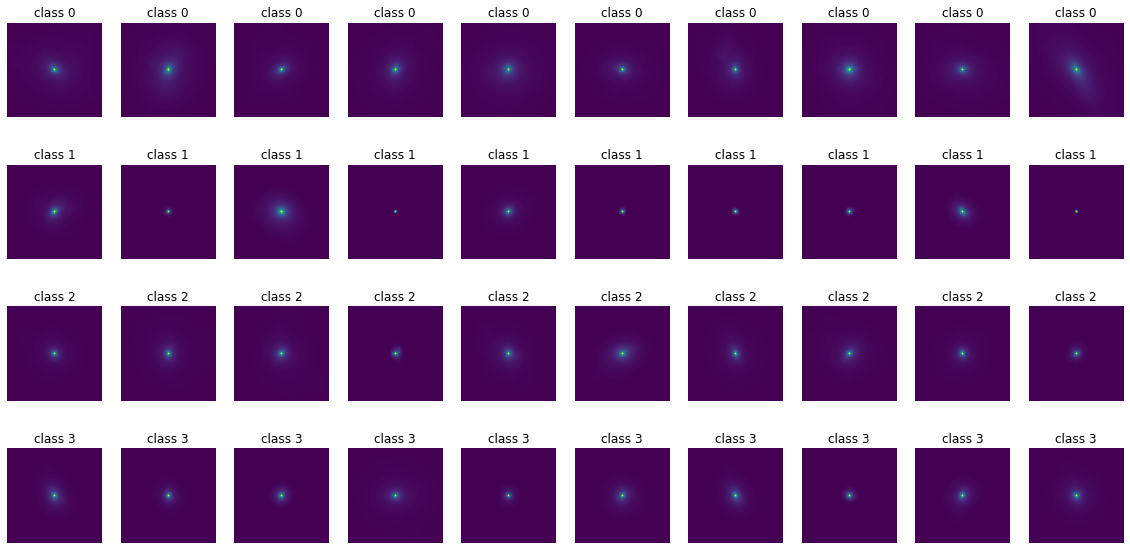

In [128]:
print('Examples of Input Image 1 by Class')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], 10, figsize=(20,10))
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 10)
    for j in range(10):
        ax[i,j].imshow(reshape_input(dataset1.X[class_samples[j]],1))
        ax[i,j].set_title('class {}'.format(i))
        ax[i,j].axis('off')
plt.show()


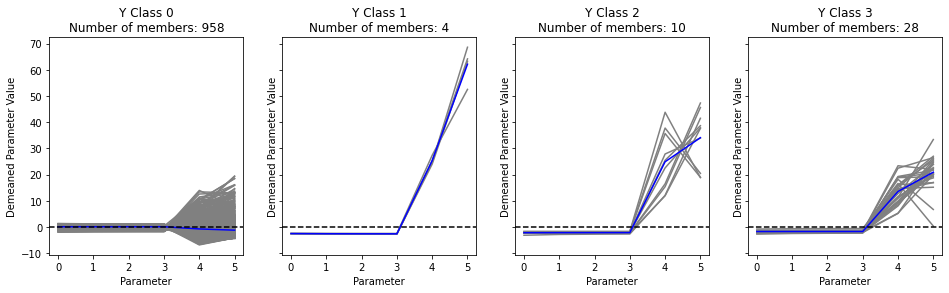

In [126]:
fig,ax = plt.subplots(1,cluster_params['n_Yclusters'],figsize=(16,4),sharex=True,sharey=True)
ymean = dataset1.Y.mean(axis=0)
for i in range(cluster_params['n_Yclusters']):
    ax[i].plot((dataset1.Y[ylbls==i]-ymean).T,c='gray')
    ax[i].plot(np.mean((dataset1.Y[ylbls==i]-ymean),axis=0).T,c='blue')
    ax[i].axhline(0, linestyle='--', c='black')
    ax[i].set_xticks(range(6))
    ax[i].set_xlabel('Parameter')
    ax[i].set_ylabel('Demeaned Parameter Value')
    ax[i].set_title('Y Class {}\nNumber of members: {}'.format(i, np.sum(ylbls==i)))
plt.show()
